In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import matthews_corrcoef

from pandas.tools.plotting import scatter_matrix
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns



%matplotlib inline
pylab.rcParams['figure.figsize'] = 12,8

In [2]:
df = pd.read_csv("processed_loans_2007.csv")
#print(df.columns)
df.drop(["Unnamed: 0"],axis=1, inplace=True) #index from the last export on cleaning steps
print(df.columns)
df.shape

Index(['loan_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc',
       'loan_status', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'term_ 36 months',
       'term_ 60 months'],
      dtype='object')


(37675, 38)

In [3]:
df.loan_status.value_counts(normalize=True)

1    0.856961
0    0.143039
Name: loan_status, dtype: float64

It seems that we have a problem with class imbalance. Therefore, it's not a good idea to just train it with the normal accuracy benchmarks. That would be superficially high and would not be helpful in our predictions. This is a good example to use high recall(true positive) and low fallout (false positive) rates for evaluation.

True positive rate = (True postives)/(True positives + false negatives).
False positive rate = (false positives)/(false positive + true negatives).
We'll use the ROC (receiver operating characteristic), and AUC (Area Under Curve) benchmark. Essentially, we want to look at the True positive Rate and False positive Rate

# Exloratory Analysis

In [4]:
df.corr()["loan_status"].sort_values()

int_rate                              -0.210814
term_ 60 months                       -0.171194
revol_util                            -0.099547
purpose_small_business                -0.078515
inq_last_6mths                        -0.070536
loan_amnt                             -0.062140
pub_rec                               -0.050193
dti                                   -0.042815
verification_status_Verified          -0.041976
installment                           -0.030309
purpose_debt_consolidation            -0.021098
home_ownership_RENT                   -0.020678
delinq_2yrs                           -0.019279
emp_length                            -0.016195
purpose_other                         -0.015565
revol_bal                             -0.007141
purpose_renewable_energy              -0.006921
home_ownership_OTHER                  -0.006418
purpose_house                         -0.006330
purpose_educational                   -0.006167
verification_status_Source Verified   -0

Initial looks show no clear dominant feature on our data, thus the weights and contributions of any feature should not overwhelm the rest of the features. There are however, a few key points that we would like to look at to see if there's any special information we can get out of our data.

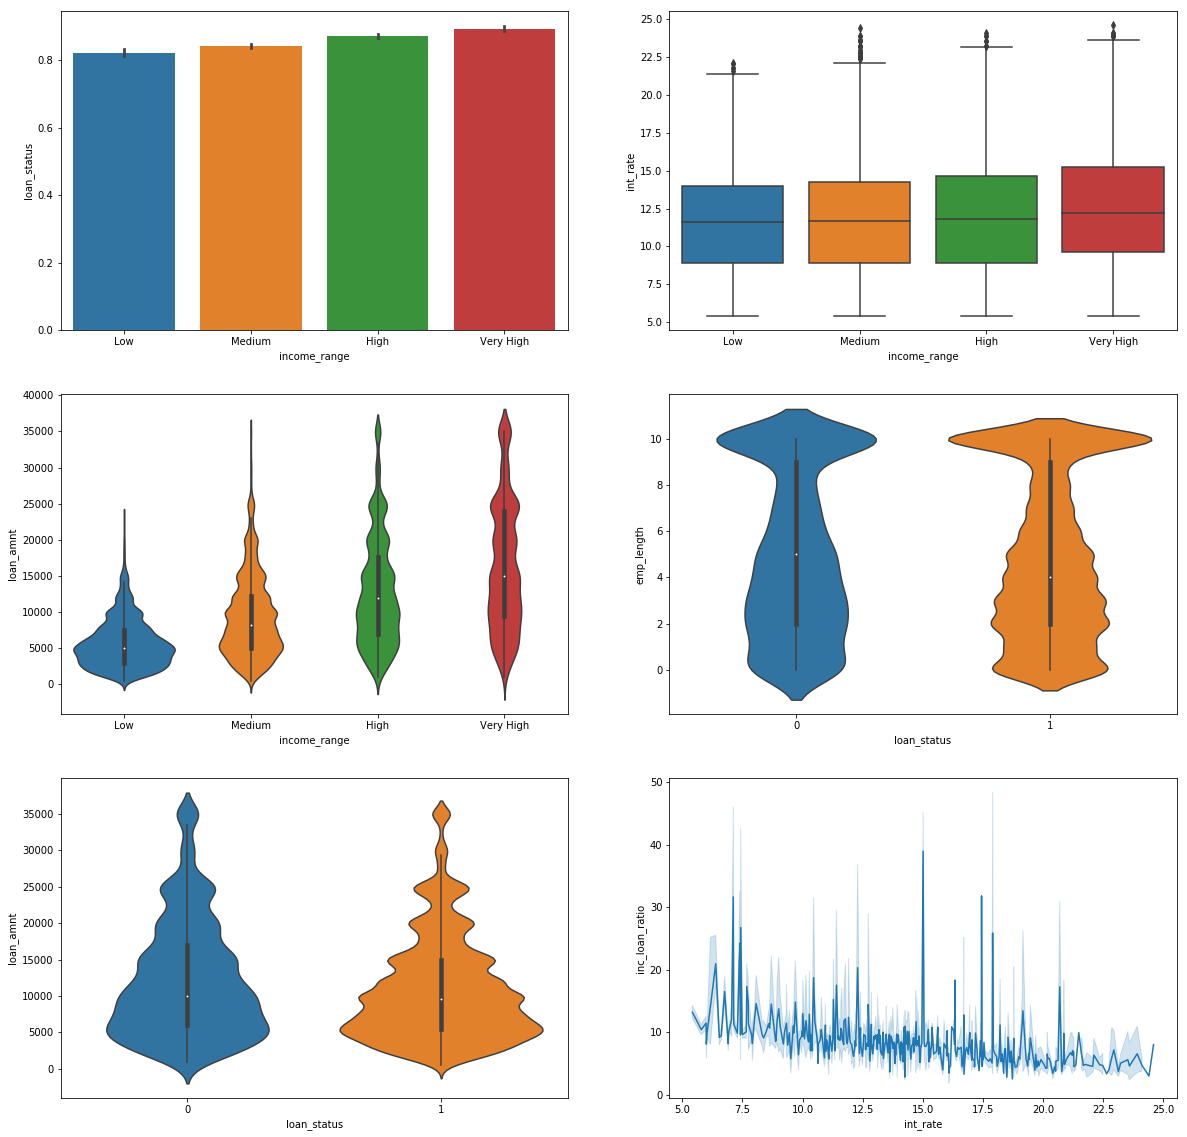

In [5]:
vis_df = df.copy()
def inc_range(row):
    if row <= 30000:
        return "Low"
    elif (row >30000) and (row <= 60000):
        return "Medium"
    elif (row > 60000) and (row < 100000):
        return "High"
    else:
        return "Very High"
    
vis_df["income_range"] = vis_df["annual_inc"].apply(inc_range)
vis_df["inc_loan_ratio"] = vis_df["annual_inc"]/vis_df["loan_amnt"]
fig, ((ax1, ax2), (ax3, ax4),(ax5, ax6))= plt.subplots(nrows=3, ncols=2, figsize=(20,20))
sns.barplot(x="income_range", y="loan_status", data=vis_df,ax=ax1) #ax = ax1
sns.boxplot(x="income_range",y="int_rate",data=vis_df,ax=ax2)
sns.violinplot(x="income_range",y="loan_amnt",data=vis_df,ax=ax3)
sns.violinplot(x="loan_status",y="emp_length",data=vis_df,ax=ax4)
sns.violinplot(x="loan_status",y="loan_amnt",data=vis_df,ax=ax5)

sns.lineplot(x="int_rate",y="inc_loan_ratio",data=vis_df,ax=ax6)

What have we learned based on those plots?
1. People who has earned more are more likely to pay off the loans. This is very much expected. However, on average, we would've guessed that the difference might be bigger.
2. Pretty much the interest rate in general are the same across all borrowers. Higher income does not neccessarily require a higher interest. This is balanced by the fact that people of lower income tends to borrow less money in general (plot #3).
3. The amount of money borrowed varied, and has a higher spread as income level increases. This makes sense because one probably cannot borrow to buy a house with a very low income. It's just very unlikely.
4. There seems to be no difference on the decision of lending money based on employment length. However, it's interesting to note that people who has worked longer are less likely to apply for a loan(aside from the fact that we grouped everyone who has 10+ years of employment, thus exaggerating its meaning).
5. Plot #5 is just another way to look at plot #1 and plot #3, confirming the fact that most of the loan applications aren't high in values.
6. We took a income/loan ratio and see if it's correlated to the interest rate. Infact, it's quite clear (aside from occasional high points), that people who doesn't make much money and needed a big loan tend to have a higher interest rate. This is by far the best predictor in our loan approval technique.

# Let's utilize the raw data to see other trends in this dataset

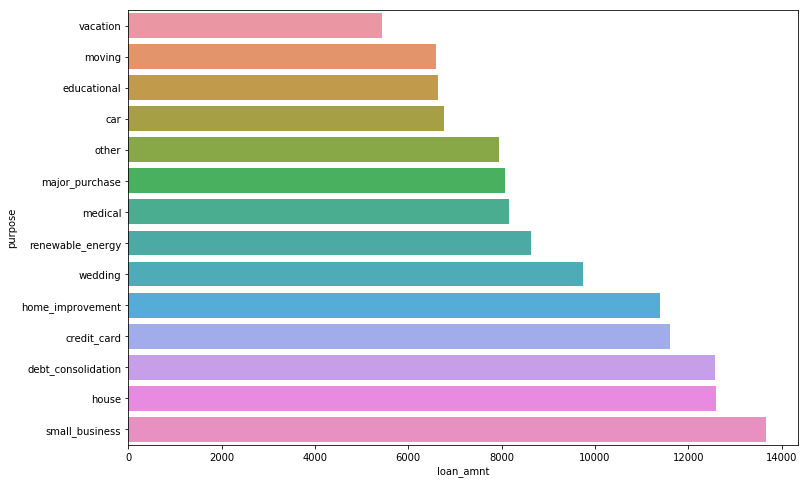

In [6]:
df_raw = pd.read_csv("loans_2007.csv")
#to group, take a mean of each column, and sort them for a prettier graph
temp = df_raw.groupby("purpose").mean().sort_values("loan_amnt").reset_index()
sns.barplot(x="loan_amnt",y="purpose",data=temp)

Finally, we import the older raw dataset to see our customer profile and the loan purposes. Which represented the consumer profile. Obviously, small businesses and bigger traps like credit card debts, wedding, and home improvement represented on average a higher loan_amnt per request. It's a good thing that based on our plot #5 above, the approval rate isn't neccessarily dictated by the loan amount. It is the utmost importance that the borrower can pay for it with a higher salary based on our plot #6. Else, we compensate for the risks with the higher interest rate.

In [7]:
#reprocessing for some of the raw data to look extra into the analysis
df_raw["income_range"] = df_raw["annual_inc"].apply(inc_range)
df_raw['int_rate'] = df_raw['int_rate'].str.rstrip('%')
df_raw['int_rate'] = df_raw['int_rate'].astype('float')
df_raw["inc_loan_ratio"] = df_raw["annual_inc"]/df_raw["loan_amnt"]

print(df_raw.columns)

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens', 'income_range', 'inc_loan_ratio'],
      dtype='object')


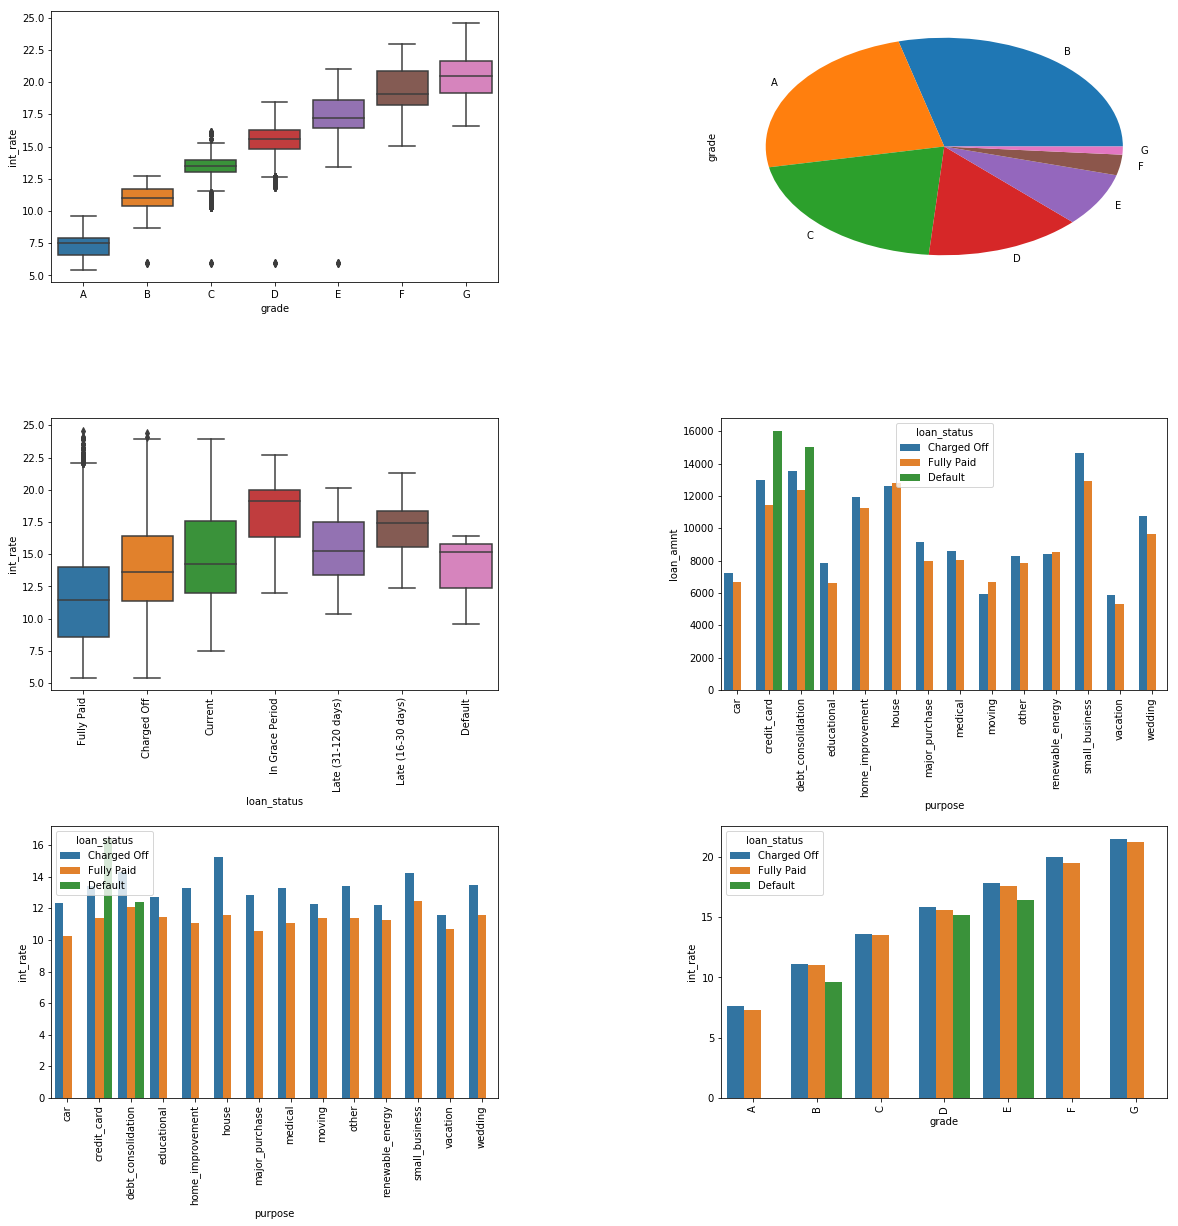

In [8]:
def plot3(df_raw):
    temp = df_raw[~df_raw['loan_status'].isin(["Does not meet the credit policy. Status:Fully Paid",
                                               "Does not meet the credit policy. Status:Charged Off"])]
    sns.boxplot(x="loan_status", y="int_rate", data=temp,ax=ax3) #charge off and default rate needs to be high
    ax3.set_xticklabels(ax3.get_xticklabels(),rotation=90)


#helper function with plot #4. Mean loan_amnt for various purposes
def plot4(df_raw):
    temp = df_raw.loc[df_raw['loan_status'].isin(['Charged Off','Default','Fully Paid'])]
    temp = temp.groupby(["purpose","loan_status"]).mean()
    temp.reset_index(inplace = True)
    sns.barplot(x="purpose",y="loan_amnt",hue="loan_status",data=temp,ax=ax4)
    ax4.set_xticklabels(ax4.get_xticklabels(),rotation=90)

#helper function with plot #5. Which loan purpose can generate most values without being the most risky
def plot5(df_raw):
    temp = df_raw.loc[df_raw['loan_status'].isin(['Charged Off','Default','Fully Paid'])]
    temp = temp.groupby(["purpose","loan_status"]).mean()
    temp.reset_index(inplace = True)
    sns.barplot(x="purpose",y="int_rate",hue="loan_status",data=temp,ax=ax5)
    ax5.set_xticklabels(ax5.get_xticklabels(),rotation=90)

#helper function with plot #6. Can we count on the fact that higher credits loans are safer in general?
#this is an essential question to recap our data
def plot6(df_raw):
    temp = df_raw.loc[df_raw['loan_status'].isin(['Charged Off','Default','Fully Paid'])]
    temp = temp.groupby(["grade","loan_status"]).mean()
    temp.reset_index(inplace = True)
    sns.barplot(x="grade",y="int_rate",hue="loan_status",data=temp,ax=ax6)
    ax6.set_xticklabels(ax6.get_xticklabels(),rotation=90)

fig, ((ax1, ax2), (ax3, ax4),(ax5, ax6))= plt.subplots(nrows=3, ncols=2, figsize=(20,20))
plt.subplots_adjust(hspace=0.5, wspace=0.5) #to adjust spacings between plots
sns.boxplot(x="grade", y="int_rate", data=df_raw,order=["A","B","C","D","E","F","G"],ax=ax1)
df_raw["grade"].value_counts().plot(kind='pie', subplots=True, figsize=(8,8),ax=ax2)
plot3(df_raw)
plot4(df_raw)
plot5(df_raw)
plot6(df_raw)

#plot income with grade
#loan status default with grade
#loan purpose and default grade
#percentage of paid off based on each grades

It seems that there's no free lunch here. Lastly, we'll look at the ratio of income/loans and loan_status
1. Grades are based off from interest rate. It makes sense to remove them for our analysis
2. Most of our loans are reasonably safe, at the grades of A,B,C, and D.
3. On average, our loans with lower interest rate has a higher chance to be paid off. Perhaps, below 11% is a good bet.
4 & 5. No clear trend on which category of loan has the best paid-off/charge off ratio. We also had a couple of defaults in the credit card category (this is insignificant amount compared to fully paid and charge-off).
6. Again, we see interest rate with grade assigned for each loan. However, it's interesting to note that there is no clear trend as to why high quality loans don't have a higher fully paid/charge-off ratio.

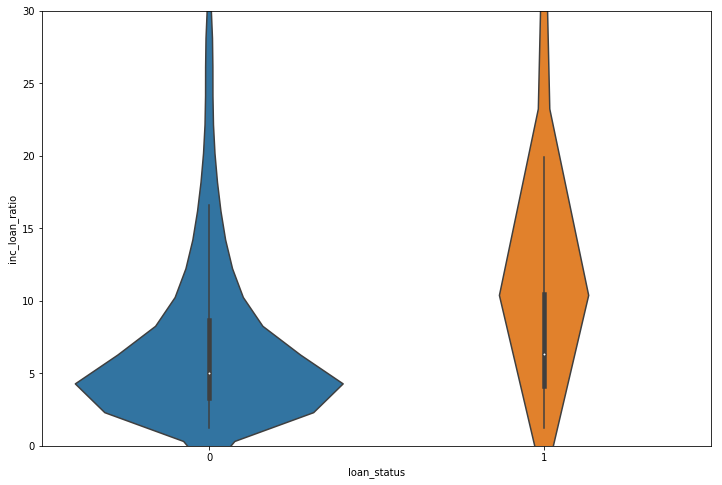

In [9]:
#print(vis_df.shape)
sns.violinplot(x="loan_status",y="inc_loan_ratio",data=vis_df)
plt.ylim(0,30)
plt.show()

Finally, the 10x and above - "income" to "loan amount" ratio certainly helps secure our full payments. At 10x the ratio, it's safe to say that there will be statistically more people who's going to pay off their loans. It doesn't guarantee if the bad loans will be covered with the good loans however.

# Machine Learning Algorithms - Part 1

For this problem, we'll divide it into 2 parts. For the first part, we'll worry ourselves with algorithms that does not need feature scaling, and for the second part, we'll use feature scaling algorithms.
Since we do have a non-balance classification, we need something other than accuracy. The standard convention would be using roc, auc. Thus, we'll be looking at precision vs recall.

precision = tp/(tp+fp)

recall = tp/(tp+fn)

self-note: for normalization, use knn+svc(0 centered, normalized stdev)+network+lasso(0 centered, normalized stdev)+ridge(0 centered, normalized stdev) + sgdclassifier + perceptron.


In [10]:
#custom scorer
scoring = {
    "accuracy":make_scorer(accuracy_score),
    "precision":make_scorer(precision_score),
    "recall":make_scorer(recall_score),
    "mcc":make_scorer(matthews_corrcoef)
}

In [11]:
#Spreadsheet of algorithms to filter initially
#https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/
tree_algs = [tree.DecisionTreeClassifier(), tree.ExtraTreeClassifier(),XGBClassifier()] #gradient boosted tree

ensemble_algs = [ensemble.AdaBoostClassifier(), ensemble.BaggingClassifier(), ensemble.ExtraTreesClassifier(),
                ensemble.GradientBoostingClassifier(), ensemble.RandomForestClassifier()]
linear_algs = [linear_model.LogisticRegressionCV()]
da_algs = [discriminant_analysis.LinearDiscriminantAnalysis(), discriminant_analysis.QuadraticDiscriminantAnalysis()]

In [12]:
features = df.columns.tolist()
features.remove("loan_status")
target = "loan_status"
print(features)

def baseline_ml(algs,features,target,scoring,df):
    
    X_train, X_test, y_train, y_test = model_selection.train_test_split(df[features], df[target], test_size=0.25, random_state=1)
    #print(X_train.shape,X_test.shape,y_train.shape, y_test.shape)
    #making a dataframe spreadsheet of ML Algorithms performances
    
    ml_cols = ["ML_alg","ML_params","ML_runtime","ML_train_accuracy","ML_train_precision","ML_train_recall","ML_train_mcc",
               "ML_test_accuracy","ML_test_precision","ML_test_recall","ML_test_mcc"]
    ml_table = pd.DataFrame(columns=ml_cols)

    #ml_pred = y_test

    row_ind = 0
    for alg in algs:

        cv_results = model_selection.cross_validate(alg, X_train, y_train, scoring=scoring, cv=10) #main object
        #print(cv_results)
        #fill in the table by calling attributes from the cv_results object
        alg_name = alg.__class__.__name__
        ml_table.loc[row_ind, 'ML_alg'] = alg_name
        ml_table.loc[row_ind, 'ML_params'] = str(alg.get_params())
        ml_table.loc[row_ind, 'ML_runtime'] = cv_results['fit_time'].mean()
        ml_table.loc[row_ind, 'ML_train_accuracy'] = cv_results['train_accuracy'].mean()
        ml_table.loc[row_ind, 'ML_train_precision'] = cv_results['train_precision'].mean()
        ml_table.loc[row_ind, 'ML_train_recall'] = cv_results['train_recall'].mean() 
        ml_table.loc[row_ind, 'ML_train_mcc'] = cv_results['train_mcc'].mean()

        ml_table.loc[row_ind, 'ML_test_accuracy'] = cv_results['test_accuracy'].mean()
        ml_table.loc[row_ind, 'ML_test_precision'] = cv_results['test_precision'].mean()
        ml_table.loc[row_ind, 'ML_test_recall'] = cv_results['test_recall'].mean() 
        ml_table.loc[row_ind, 'ML_test_mcc'] = cv_results['test_mcc'].mean()

        alg.fit(X_train, y_train)
        #prediction needs to be returned later for a second stage ensemble
        ml_pred = alg.predict(X_test)
        #print(cv_results)

        row_ind += 1
    return ml_table, ml_pred

['loan_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'home_ownership_MORTGAGE', 'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Not Verified', 'verification_status_Source Verified', 'verification_status_Verified', 'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other', 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation', 'purpose_wedding', 'term_ 36 months', 'term_ 60 months']


In [13]:
#Spreadsheet of algorithms to filter initially
tree_table,temp = baseline_ml(tree_algs,features,target,scoring,df)
tree_table

ML_alg                                          ML_params  \
0  DecisionTreeClassifier  {'class_weight': None, 'criterion': 'gini', 'm...   
1     ExtraTreeClassifier  {'class_weight': None, 'criterion': 'gini', 'm...   
2           XGBClassifier  {'base_score': 0.5, 'booster': 'gbtree', 'cols...   

  ML_runtime ML_train_accuracy ML_train_precision ML_train_recall  \
0   0.349819                 1                  1               1   
1  0.0413854                 1                  1               1   
2    4.44891          0.859208           0.859449        0.999345   

  ML_train_mcc ML_test_accuracy ML_test_precision ML_test_recall ML_test_mcc  
0            1          0.76313          0.868443       0.853207   0.0687824  
1            1         0.766987          0.866222       0.861497   0.0563333  
2    0.0833291         0.857552          0.858536       0.998515   0.0353823

In [14]:
ensemble_table,temp = baseline_ml(ensemble_algs,features,target,scoring,df)
ensemble_table

ML_alg  \
0          AdaBoostClassifier   
1           BaggingClassifier   
2        ExtraTreesClassifier   
3  GradientBoostingClassifier   
4      RandomForestClassifier   

                                           ML_params ML_runtime  \
0  {'algorithm': 'SAMME.R', 'base_estimator': Non...    1.18802   
1  {'base_estimator': None, 'bootstrap': True, 'b...     2.3498   
2  {'bootstrap': False, 'class_weight': None, 'cr...   0.323692   
3  {'criterion': 'friedman_mse', 'init': None, 'l...    3.32369   
4  {'bootstrap': True, 'class_weight': None, 'cri...   0.444964   

  ML_train_accuracy ML_train_precision ML_train_recall ML_train_mcc  \
0          0.858197           0.860761        0.995825    0.0903466   
1          0.992721           0.992614        0.998951     0.969885   
2                 1                  1               1            1   
3          0.860824           0.861132        0.998882     0.128638   
4          0.992529           0.992146        0.999203     0.969085   

  ML_test_accuracy ML_test_precision ML_test_recall ML_test_mcc  
0         0.856845          0.860149       0.994927   0.0692022  
1         0.831186          0.866033       0.950258   0.0917121  
2         0.838265          0.865098       0.961435   0.0917123  
3         0.857163          0.859067       0.997113   0.0452702  
4          0.84099          0.864836       0.965601    0.092431

In [15]:
linear_table,temp = baseline_ml(linear_algs,features,target,scoring,df)
linear_table

ML_alg                                          ML_params  \
0  LogisticRegressionCV  {'Cs': 10, 'class_weight': None, 'cv': 'warn',...   

  ML_runtime ML_train_accuracy ML_train_precision ML_train_recall  \
0    1.23817          0.857647           0.858374        0.998909   

  ML_train_mcc ML_test_accuracy ML_test_precision ML_test_recall ML_test_mcc  
0    0.0242375         0.857482          0.858373        0.99868   0.0257758

In [16]:
da_table,temp = baseline_ml(da_algs,features,target,scoring,df)
da_table

ML_alg  \
0     LinearDiscriminantAnalysis   
1  QuadraticDiscriminantAnalysis   

                                           ML_params ML_runtime  \
0  {'n_components': None, 'priors': None, 'shrink...   0.175533   
1  {'priors': None, 'reg_param': 0.0, 'store_cova...  0.0890451   

  ML_train_accuracy ML_train_precision ML_train_recall ML_train_mcc  \
0          0.856837           0.860107        0.994982    0.0683083   
1          0.144925           0.886857      0.00392749   0.00558959   

  ML_test_accuracy ML_test_precision ML_test_recall ML_test_mcc  
0         0.856455          0.859966       0.994679     0.06333  
1         0.144607          0.866712     0.00362982  0.00149619

In [17]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df[features], df[target], test_size=0.25, random_state=1)
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

1    0.858048
0    0.141952
Name: loan_status, dtype: float64
1    0.8537
0    0.1463
Name: loan_status, dtype: float64


In [18]:
#so our baseline prediction is (let's assume everything is 1 for our loan target)
acc_baseline = 0.85 #a very meaningless stats here
prec_baseline = 0.85/(0.85+0.15)
rec_baseline = 0.85/(0.85+0) #we never predict 0 for false negative

print("accuracy baseline: ",acc_baseline, "\nprecision baseline: ", prec_baseline, "\nrecall_baseline: ",rec_baseline)
print("Keep in mind that the recall baseline is meaningless here since we don't predict 0 at all.\nHowever, we can see that it's very high toward 1")
print("Therefore, let's use a different benchmark to tune in our data, Mathew Correlation Coefficient.\nA -1 means we classified everything wrong. A 1 mean we classified everything right")
print("MCC is a balanced metric, so our imbalanced dataset is good enough.")

accuracy baseline:  0.85 
precision baseline:  0.85 
recall_baseline:  1.0
Keep in mind that the recall baseline is meaningless here since we don't predict 0 at all.
However, we can see that it's very high toward 1
Therefore, let's use a different benchmark to tune in our data, Mathew Correlation Coefficient.
A -1 means we classified everything wrong. A 1 mean we classified everything right
MCC is a balanced metric, so our imbalanced dataset is good enough.


# Algorithms Focus #1:

What we've learned?
Our tree models are overfitting, which is expected in the default state (this is also seen with perfect/near perfect score on the training set).
The overfitting continues with ensemble algorithms.
Logistic regression seems to be competitive enough but the MCC score suggests that it's underperforming when taken all 4 confusion matrices into account
Surprisingly, LDA yield some decent results, comparable to Trees and ensemble. This is not expected since our data is mixed (both continuous and binary/categorical), thus not all of them are "truly" normal. We can explore later on that.

Let's keep:
XGBClassifier, all of the ensemble techniques, and LDA.

In [19]:
#let's put them all in a table
algs_set1 = [XGBClassifier(),ensemble.AdaBoostClassifier(), ensemble.BaggingClassifier(), ensemble.ExtraTreesClassifier(),
            ensemble.GradientBoostingClassifier(), ensemble.RandomForestClassifier(), discriminant_analysis.LinearDiscriminantAnalysis()] 
table_set1,temp = baseline_ml(algs_set1,features,target,scoring,df)
table_set1

ML_alg  \
0               XGBClassifier   
1          AdaBoostClassifier   
2           BaggingClassifier   
3        ExtraTreesClassifier   
4  GradientBoostingClassifier   
5      RandomForestClassifier   
6  LinearDiscriminantAnalysis   

                                           ML_params ML_runtime  \
0  {'base_score': 0.5, 'booster': 'gbtree', 'cols...    4.33702   
1  {'algorithm': 'SAMME.R', 'base_estimator': Non...    1.18578   
2  {'base_estimator': None, 'bootstrap': True, 'b...    2.26898   
3  {'bootstrap': False, 'class_weight': None, 'cr...   0.329619   
4  {'criterion': 'friedman_mse', 'init': None, 'l...     3.2725   
5  {'bootstrap': True, 'class_weight': None, 'cri...   0.444668   
6  {'n_components': None, 'priors': None, 'shrink...   0.172069   

  ML_train_accuracy ML_train_precision ML_train_recall ML_train_mcc  \
0          0.859208           0.859449        0.999345    0.0833291   
1          0.858197           0.860761        0.995825    0.0903466   
2          0.992564           0.992501        0.998882     0.969229   
3                 1                  1               1            1   
4          0.860824           0.861132        0.998882     0.128638   
5          0.992768           0.992238         0.99939     0.970088   
6          0.856837           0.860107        0.994982    0.0683083   

  ML_test_accuracy ML_test_precision ML_test_recall ML_test_mcc  
0         0.857552          0.858536       0.998515   0.0353823  
1         0.856845          0.860149       0.994927   0.0692022  
2         0.831611          0.866897       0.949557   0.0998711  
3         0.837274           0.86374       0.962136   0.0758645  
4         0.857163          0.859067       0.997113   0.0452702  
5         0.841838          0.865438       0.965848    0.100673  
6         0.856455          0.859966       0.994679     0.06333

In [20]:
#we're going to use a benchmark of Mathew's correlation coefficent to determine our imbalanced dataset.
#refer to:https://lettier.github.io/posts/2016-08-05-matthews-correlation-coefficient.html
#we can also try the "balanced_accuracy" scorer, which is also designed for imbalanced dataset. It takes into account of the average macro recall.
#Let's stick with the former.

mcc_scorer = make_scorer(matthews_corrcoef)

def tuning_grid(model_,features,target,hyperparams,df):
    global mcc_scorer
    X_train, X_test, y_train, y_test = model_selection.train_test_split(df[features], df[target], test_size=0.25, random_state=1)
    model = model_selection.GridSearchCV(model_,param_grid=hyperparams,scoring=mcc_scorer, cv = 10)
    model.fit(X_train,y_train)
    print(model.best_params_)
    print(model.cv_results_['mean_train_score'])
    print(model.cv_results_['mean_test_score'])
    return model

In [21]:
#fine-tunning hyperparameters with GridsearchCV
#Store the estimators in this dictionary for later usage
hyper_tuning = {}
Y_pred = pd.DataFrame()

In [22]:
XGBClassifier_hp = {"eta":[0.1,0.2], #learning rate
                    "min_child_weight":[1], #“sum of weights” of observations while GBM has min “number of observations”.
                    #used lower number because of class imbalance
                    "max_depth":[3,6,9,13], #pruning to control overfitting
                    "scale_pos_weight":[0.17,0.1] #the ratio of positive to negative (0.15/0.85), imbalanced dataset
                   }

#manually optimize, testing
#tune_model = model_selection.GridSearchCV(XGBClassifier(),param_grid=XGBClassifier_hp,scoring="matthews_corrcoef", cv = 2)
#fit to tune the gridsearch
#tune_model.fit(X_test,y_test)

#print(tune_model.cv_results_.keys())
#print(tune_model.cv_results_['params'])
#print(tune_model.best_params_)

In [23]:
'''
XGB_model = tuning_grid(XGBClassifier(),features,target,XGBClassifier_hp,df)
XGB_model
'''

'\nXGB_model = tuning_grid(XGBClassifier(),features,target,XGBClassifier_hp,df)\nXGB_model\n'

In [24]:
current_model = [XGBClassifier(eta=0.1, max_depth=3, min_child_weight=1,scale_pos_weight=0.17,random_state=1)]
current_table,y_pred = baseline_ml(current_model,features,target,scoring,df)
#assigning the best XGBClassfier hyperparameters we have
hyper_tuning["XGBClassifier"] = current_model
Y_pred["XGBClassifier"] = y_pred
current_table
#we did improve the mcc value quite a bit here from the default. It's not perfect but we'll stick with it.
#at the expense, we have been lowering our recall rate.



ML_alg                                          ML_params  \
0  XGBClassifier  {'base_score': 0.5, 'booster': 'gbtree', 'cols...   

  ML_runtime ML_train_accuracy ML_train_precision ML_train_recall  \
0    4.32729          0.667253           0.925267        0.665998   

  ML_train_mcc ML_test_accuracy ML_test_precision ML_test_recall ML_test_mcc  
0     0.244779         0.653701          0.914324       0.658114    0.204821

In [25]:
#AdaBoostClassfier, max_depth has to be minimum of 3 to perform better than random guesses(error).
#we want weak learners so we use max_depth=3 for each learner.
'''
AdaBoostClassifier_hp = {"base_estimator":[tree.DecisionTreeClassifier(class_weight='balanced',max_depth=3)],
                         "n_estimators":[100,250,400,550],"learning_rate":[0.3,0.6,1,1.5],
                         "algorithm":["SAMME","SAMME.R"],"random_state":[1]}
AdaBoostClassifier_model = tuning_grid(ensemble.AdaBoostClassifier(),features,target,AdaBoostClassifier_hp,df)
AdaBoostClassifier_model
'''

'\nAdaBoostClassifier_hp = {"base_estimator":[tree.DecisionTreeClassifier(class_weight=\'balanced\',max_depth=3)],\n                         "n_estimators":[100,250,400,550],"learning_rate":[0.3,0.6,1,1.5],\n                         "algorithm":["SAMME","SAMME.R"],"random_state":[1]}\nAdaBoostClassifier_model = tuning_grid(ensemble.AdaBoostClassifier(),features,target,AdaBoostClassifier_hp,df)\nAdaBoostClassifier_model\n'

In [26]:
#the learning rate and n_estimators are inversely related (somewhat) due to the effectiveness of each weak leaner.
#using balanced decisiontree for class imbalance, keep default hyperparam
current_model = [ensemble.AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(class_weight='balanced',max_depth=3),
                                             n_estimators=100,learning_rate=0.3,algorithm="SAMME.R",random_state=1)]
current_table, y_pred = baseline_ml(current_model,features,target,scoring,df)
hyper_tuning["AdaBoostClassifier"] = current_model
Y_pred["AdaBoostClassifier"] = y_pred
current_table

ML_alg                                          ML_params  \
0  AdaBoostClassifier  {'algorithm': 'SAMME.R', 'base_estimator__clas...   

  ML_runtime ML_train_accuracy ML_train_precision ML_train_recall  \
0    6.75197          0.688487           0.941036        0.679531   

  ML_train_mcc ML_test_accuracy ML_test_precision ML_test_recall ML_test_mcc  
0     0.303481         0.654091          0.909004        0.66327    0.188922

In [27]:
#max_samples is for the number of observations being used max_samples*total_sample_size
#max_features = max_features*total_features
#same weak learner as the previous AdaBoost for the base_estimator
'''
BaggingClassifier_hp = {"base_estimator":[tree.DecisionTreeClassifier(class_weight='balanced',max_depth=3)],
                        "n_estimators":[10,30,50,70,90],"max_samples":[0.7,1],"max_features":[0.5,0.7,1],"random_state":[1]}
BaggingClassifier_model = tuning_grid(ensemble.BaggingClassifier(),features,target,BaggingClassifier_hp,df)
BaggingClassifier_model
'''

'\nBaggingClassifier_hp = {"base_estimator":[tree.DecisionTreeClassifier(class_weight=\'balanced\',max_depth=3)],\n                        "n_estimators":[10,30,50,70,90],"max_samples":[0.7,1],"max_features":[0.5,0.7,1],"random_state":[1]}\nBaggingClassifier_model = tuning_grid(ensemble.BaggingClassifier(),features,target,BaggingClassifier_hp,df)\nBaggingClassifier_model\n'

In [28]:
#the learning rate and n_estimators are inversely related (somewhat) due to the effectiveness of each weak leaner.
#perhaps one of the better mcc value thus far.
current_model = [ensemble.BaggingClassifier(base_estimator=tree.DecisionTreeClassifier(class_weight='balanced',max_depth=3),
                                            n_estimators=30,max_samples=0.7,max_features=0.5,random_state=1)] 
current_table, y_pred = baseline_ml(current_model,features,target,scoring,df)
Y_pred["BaggingClassifier"] = y_pred
hyper_tuning["BaggingClassifier"] = current_model
current_table

ML_alg                                          ML_params  \
0  BaggingClassifier  {'base_estimator__class_weight': 'balanced', '...   

  ML_runtime ML_train_accuracy ML_train_precision ML_train_recall  \
0   0.692997          0.632491            0.91675        0.628808   

  ML_train_mcc ML_test_accuracy ML_test_precision ML_test_recall ML_test_mcc  
0      0.20114         0.629708          0.914839       0.626852    0.194195

In [29]:
#balanced weight = 0.85/0.15 = 0.56
ExtraTreeClassifier_hp = {"class_weight":["balanced",{0:1,1:1},{0:7,1:1},{0:10,1:1}],"criterion":["gini","entropy"],
                          "max_depth":[5,10,15],"min_samples_leaf":[3,6,9,12],"random_state":[1]}
ExtraTreeClassifier_model = tuning_grid(tree.ExtraTreeClassifier(),features,target,ExtraTreeClassifier_hp,df)
ExtraTreeClassifier_model


{'class_weight': {0: 7, 1: 1}, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 3, 'random_state': 1}
[0.16497609 0.16646523 0.16674616 0.16628441 0.19988616 0.19573471
 0.19385097 0.18982961 0.27844967 0.2439227  0.2324477  0.21875463
 0.16424081 0.1664477  0.16662532 0.16617682 0.19913531 0.19179301
 0.18724195 0.19087626 0.28123639 0.25147506 0.2338381  0.21909615
 0.02304466 0.01662935 0.01812124 0.00339794 0.1280625  0.10574389
 0.08782835 0.07089721 0.24843353 0.16240126 0.11051315 0.08424396
 0.02510436 0.0199241  0.01571572 0.00339794 0.13295191 0.10715647
 0.08173359 0.06791703 0.2426603  0.15709783 0.10617698 0.08318226
 0.16309603 0.16184834 0.16358479 0.16313754 0.1930427  0.1843285
 0.18009922 0.18081472 0.27301719 0.23726052 0.22082489 0.21238359
 0.16141114 0.16184834 0.16358479 0.16303061 0.19224009 0.18159304
 0.17892124 0.18598619 0.26923866 0.23612044 0.21981804 0.2119846
 0.09507673 0.08362779 0.0973717  0.10599437 0.16166197 0.15581148
 0.14792189 0.1557583

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, random_state=None,
          splitter='random'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'class_weight': ['balanced', {0: 1, 1: 1}, {0: 7, 1: 1}, {0: 10, 1: 1}], 'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 15], 'min_samples_leaf': [3, 6, 9, 12], 'random_state': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(matthews_corrcoef), verbose=0)

In [30]:
current_model = [tree.ExtraTreeClassifier(criterion="gini", class_weight={0:7,1:1},max_depth=5, min_samples_leaf=3)]
current_table, y_pred = baseline_ml(current_model,features,target,scoring,df)
hyper_tuning["ExtraTreeClassifier"] = current_model
Y_pred["ExtraTreeClassifier"] = y_pred
current_table
#quite a good result with the fast runtime

ML_alg                                          ML_params  \
0  ExtraTreeClassifier  {'class_weight': {0: 7, 1: 1}, 'criterion': 'g...   

  ML_runtime ML_train_accuracy ML_train_precision ML_train_recall  \
0  0.0211502          0.558875           0.906442        0.544112   

  ML_train_mcc ML_test_accuracy ML_test_precision ML_test_recall ML_test_mcc  
0     0.143372         0.556371          0.904326         0.5418     0.13934

In [31]:
#refer to: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
#for hyperparameter tuning, it's unlikely to beat XGBClassifier previously
#let's do a rough estimate
'''
GBClassifier_hp = {"learning_rate":[0.05,0.1,0.15],"n_estimators":[40,60,80,100],
                   "max_features":["auto","sqrt","log2"],"max_depth":[3,6,8],"random_state":[1]}
GradientBoostingClassifier_model = tuning_grid(ensemble.GradientBoostingClassifier(),features,target,GBClassifier_hp,df)
GradientBoostingClassifier_model
'''

'\nGBClassifier_hp = {"learning_rate":[0.05,0.1,0.15],"n_estimators":[40,60,80,100],\n                   "max_features":["auto","sqrt","log2"],"max_depth":[3,6,8],"random_state":[1]}\nGradientBoostingClassifier_model = tuning_grid(ensemble.GradientBoostingClassifier(),features,target,GBClassifier_hp,df)\nGradientBoostingClassifier_model\n'

In [32]:
current_model = [ensemble.GradientBoostingClassifier(learning_rate=0.15, n_estimators=80, min_samples_split=0.005,
                                                    max_features="log2",max_depth=8, random_state=1)]
current_table, y_pred = baseline_ml(current_model,features,target,scoring,df)
hyper_tuning["GradientBoostingClassifier"] = current_model
Y_pred["GradientBoostingClassifier"] = y_pred
current_table
#long runtime and very unsatisfied result, not much better than baselines.

ML_alg  \
0  GradientBoostingClassifier   

                                           ML_params ML_runtime  \
0  {'criterion': 'friedman_mse', 'init': None, 'l...    2.19714   

  ML_train_accuracy ML_train_precision ML_train_recall ML_train_mcc  \
0          0.879105           0.877242        0.998886     0.358608   

  ML_test_accuracy ML_test_precision ML_test_recall ML_test_mcc  
0          0.85596          0.861963       0.990802   0.0939717

In [33]:
'''
RandomForestClassifier_hp = {"class_weight":["balanced"],"min_samples_split":[0.005],
                             "max_depth":[3,5,7,9,11],"n_estimators":[10,20,30,40]}
RF_model = tuning_grid(ensemble.RandomForestClassifier(),features,target,RandomForestClassifier_hp,df)
RF_model
'''

'\nRandomForestClassifier_hp = {"class_weight":["balanced"],"min_samples_split":[0.005],\n                             "max_depth":[3,5,7,9,11],"n_estimators":[10,20,30,40]}\nRF_model = tuning_grid(ensemble.RandomForestClassifier(),features,target,RandomForestClassifier_hp,df)\nRF_model\n'

In [34]:
current_model = [ensemble.RandomForestClassifier(n_estimators=40, class_weight="balanced", max_depth=11, min_samples_split=0.005)]
current_table,y_pred = baseline_ml(current_model,features,target,scoring,df)
Y_pred["RandomForestClassifier"] = y_pred
hyper_tuning["RandomForestClassifier"] = current_model
current_table
#pred.head()

ML_alg                                          ML_params  \
0  RandomForestClassifier  {'bootstrap': True, 'class_weight': 'balanced'...   

  ML_runtime ML_train_accuracy ML_train_precision ML_train_recall  \
0   0.986342          0.733779           0.934325        0.741885   

  ML_train_mcc ML_test_accuracy ML_test_precision ML_test_recall ML_test_mcc  
0     0.319584         0.697656          0.905549       0.723117    0.200576

In [35]:
#n_components = features
LDA_hp = {"solver":["svd","lsqr"],"n_components":[38,35,33,30,27,25,20]}
LDA_model = tuning_grid(discriminant_analysis.LinearDiscriminantAnalysis(),features,target,LDA_hp,df)
LDA_model

{'n_components': 38, 'solver': 'lsqr'}
[0.06830835 0.06862049 0.06830835 0.06862049 0.06830835 0.06862049
 0.06830835 0.06862049 0.06830835 0.06862049 0.06830835 0.06862049
 0.06830835 0.06862049]
[0.06332958 0.06352663 0.06332958 0.06352663 0.06332958 0.06352663
 0.06332958 0.06352663 0.06332958 0.06352663 0.06332958 0.06352663
 0.06332958 0.06352663]


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'solver': ['svd', 'lsqr'], 'n_components': [38, 35, 33, 30, 27, 25, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(matthews_corrcoef), verbose=0)

In [36]:
#as expected, we can't improve the algorithm without the penalty applied parameter in our parameter.
#let's not include it for our future usage.
current_model = [discriminant_analysis.LinearDiscriminantAnalysis(solver="lsqr")]
current_table,pred = baseline_ml(current_model,features,target,scoring,df)
current_table
#pred.shape

ML_alg  \
0  LinearDiscriminantAnalysis   

                                           ML_params ML_runtime  \
0  {'n_components': None, 'priors': None, 'shrink...   0.121106   

  ML_train_accuracy ML_train_precision ML_train_recall ML_train_mcc  \
0          0.856821           0.860128        0.994927    0.0686205   

  ML_test_accuracy ML_test_precision ML_test_recall ML_test_mcc  
0          0.85642          0.859987       0.994597   0.0635274

In [37]:
alg_set1 = list()
for key,val in hyper_tuning.items():
    alg_set1.append(val[0]) #the value itself is in a list too
#alg_set1
algset1_table, temp = baseline_ml(alg_set1,features,target,scoring,df)
algset1_table

ML_alg  \
0               XGBClassifier   
1          AdaBoostClassifier   
2           BaggingClassifier   
3         ExtraTreeClassifier   
4  GradientBoostingClassifier   
5      RandomForestClassifier   

                                           ML_params ML_runtime  \
0  {'base_score': 0.5, 'booster': 'gbtree', 'cols...    4.33653   
1  {'algorithm': 'SAMME.R', 'base_estimator__clas...    31.4052   
2  {'base_estimator__class_weight': 'balanced', '...    0.67463   
3  {'class_weight': {0: 7, 1: 1}, 'criterion': 'g...  0.0193141   
4  {'criterion': 'friedman_mse', 'init': None, 'l...    2.20232   
5  {'bootstrap': True, 'class_weight': 'balanced'...   0.975191   

  ML_train_accuracy ML_train_precision ML_train_recall ML_train_mcc  \
0          0.667253           0.925267        0.665998     0.244779   
1          0.688487           0.941036        0.679531     0.303481   
2          0.632491            0.91675        0.628808      0.20114   
3          0.572264           0.909137        0.559387      0.15116   
4          0.879105           0.877242        0.998886     0.358608   
5          0.730897           0.934604        0.738022     0.317995   

  ML_test_accuracy ML_test_precision ML_test_recall ML_test_mcc  
0         0.653701          0.914324       0.658114    0.204821  
1         0.654091          0.909004        0.66327    0.188922  
2         0.629708          0.914839       0.626852    0.194195  
3         0.566671          0.905547       0.554625    0.139874  
4          0.85596          0.861963       0.990802   0.0939717  
5         0.695392          0.906023       0.719694     0.20094

In [71]:
#Y_pred.tail()
#let's do majority voting to benchmark our first round of algorithms
#recall we already splitted the train/test dataset previously

Y_pred["Vote1"] = Y_pred.mode(axis=1)[0] #need the zero for unpacking
Y_pred

print("accuracy: ", accuracy_score(y_test,Y_pred["Vote1"]))
print("Precision: ", precision_score(y_test,Y_pred["Vote1"]))
print("Recall: ",recall_score(y_test,Y_pred["Vote1"]))
print("MCC: ",matthews_corrcoef(y_test,Y_pred["Vote1"]))


accuracy:  0.6610043529037053
Precision:  0.9180751983442567
Recall:  0.6619823405049123
MCC:  0.23049886709570724


# Summary of the Part 1 of our algorithms

As seen, accuracy are not what we wanted. If the bank would like to be a conservative investor, it is better to have a very high precision with some expenses of recall (missing out the some right calls for more higher probability of getting the predictions right. Our majority voting technique also helps get the better answer than any of the single models. Lastly, it is important to note that the MCC value maximizes the 4 quadrants of the confusion matrix, and maximize is probably the best way to do it, thus balancing both high precision with sufficient recall. Else we would be missing out of most of the investment opportunities with a high success rate.

# Algorithms focus #2

In [74]:
df.columns

Index(['loan_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc',
       'loan_status', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'term_ 36 months',
       'term_ 60 months'],
      dtype='object')

In [75]:
#we'll categorize the continous variables together first prior to standardize the continous data
df.head()

loan_amnt  int_rate  installment  emp_length  annual_inc  loan_status  \
0     5000.0     10.65       162.87          10     24000.0            1   
1     2500.0     15.27        59.83           0     30000.0            0   
2     2400.0     15.96        84.33          10     12252.0            1   
3    10000.0     13.49       339.31          10     49200.0            1   
4     5000.0      7.90       156.46           3     36000.0            1   

     dti  delinq_2yrs  inq_last_6mths  open_acc       ...         \
0  27.65          0.0             1.0       3.0       ...          
1   1.00          0.0             5.0       3.0       ...          
2   8.72          0.0             2.0       2.0       ...          
3  20.00          0.0             1.0      10.0       ...          
4  11.20          0.0             3.0       9.0       ...          

   purpose_major_purchase  purpose_medical  purpose_moving  purpose_other  \
0                       0                0               0              0   
1                       0                0               0              0   
2                       0                0               0              0   
3                       0                0               0              1   
4                       0                0               0              0   

   purpose_renewable_energy  purpose_small_business  purpose_vacation  \
0                         0                       0                 0   
1                         0                       0                 0   
2                         0                       1                 0   
3                         0                       0                 0   
4                         0                       0                 0   

   purpose_wedding  term_ 36 months  term_ 60 months  
0                0                1                0  
1                0                0                1  
2                0                1                0  
3                0                1                0  
4                1                1                0  

[5 rows x 38 columns]

In [ ]:
#we'll categorize the continous variables together first prior to standardize the continous data
cont_df = df["loan_amnt","int_rate","installment","emp_length","annual_inc","dti","delinq_2yrs","inq_last_6mths",
             "open_acc","revol_bal",""]